## Importing Necessary Libraries

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

## Loading the Data

In [2]:
import pandas as pd

train_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv',
                        encoding='latin_1')
test_data = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin_1')

In [3]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Checking for any Null Value(s)

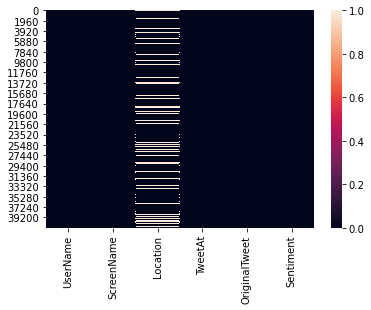

In [5]:
# check for null value in train_data
sns.heatmap(train_data.isnull());

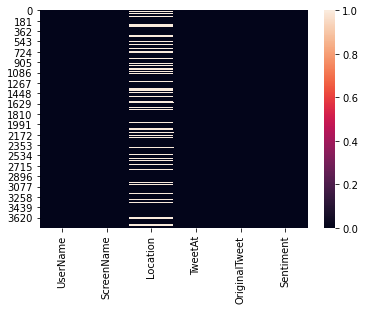

In [6]:
# check for null values in test data
sns.heatmap(test_data.isnull());

Drop Duplicate and N/A Labels

In [7]:
train_data.drop_duplicates(inplace= True)
test_data.drop_duplicates(inplace=True)

In [8]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

Making Checkpoint

In [9]:
# copy the dataset into new data
train_df = train_data.copy()
test_df = test_data.copy()

In [10]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive


Checking if any null values exist

In [11]:
print(train_df.isnull().sum())
print("*"*50)
print(test_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [12]:
train_data.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

## EDA

In [13]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})

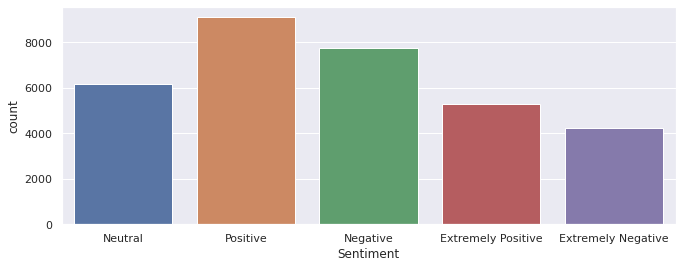

In [14]:
sns.countplot(train_df['Sentiment'])

In [15]:
train_df.shape, test_df.shape

((32567, 6), (2964, 6))

Extremely Positive, Positive -> Positive
Extremely Negative, Negative -> Negative
Neutral

In [16]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

Applying the change_sen()

In [17]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

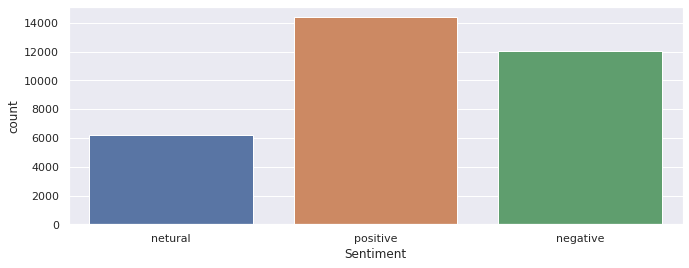

In [18]:
sns.countplot(train_df['Sentiment'])

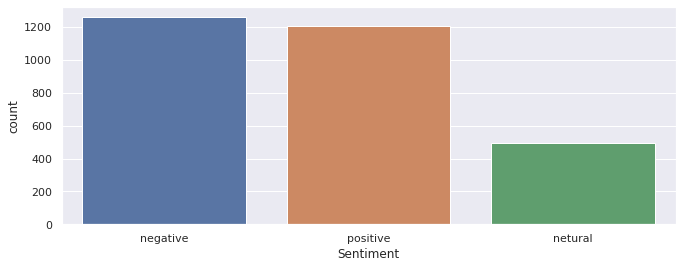

In [19]:
sns.countplot(test_df['Sentiment'])

## Data Preprocessing

In [20]:
# load stop words
stop_word = stopwords.words('english')

In [21]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
      
    return text

In [22]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))

In [23]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,netural
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news regionÂs first confirmed COVID- case ...,positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier grocery store sharing insights To prov...,positive


## Feature Selection -> Original Tweet, Sentiment

In [24]:
df_train = train_df.iloc[:,4:]
df_test = test_df.iloc[:,4:]

In [25]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


### Mapping the Sentiment

0 -> Neutral
1 -> Positive
2 -> Negative

In [26]:
l = {"netural":0, "positive":1,"negative":2}

In [27]:
df_train['Sentiment'] = df_train['Sentiment'].map(l)
df_test['Sentiment']  = df_test['Sentiment'].map(l)

In [28]:
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice Talk neighbours family exchange phone n...,1
2,Coronavirus Australia: Woolworths give elderly...,1
5,As news regionÂs first confirmed COVID- case ...,1
6,Cashier grocery store sharing insights To prov...,1


In [29]:
x_train = df_train['OriginalTweet'].copy()
x_test = df_test['OriginalTweet'].copy()

y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()

In [30]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

### Maximum Length of Sequence

In [31]:
import numpy as np
max_len = np.max(x_train.apply(lambda x :len(x)))

In [32]:
max_len

286

### Tokenizer Initialization

In [33]:
tokenizer = Tokenizer()

In [34]:
tokenizer.fit_on_texts(x_train)
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [35]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 31759
Max sequence length: 286


In [36]:
embedding_dim = 16

## Creating a Deep Learning Model

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [38]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 286, 16)           508144    
_________________________________________________________________
bidirectional (Bidirectional (None, 286, 512)          420864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 962,035
Trainable params: 962,035
Non-trainable params: 0
__________________________________________________

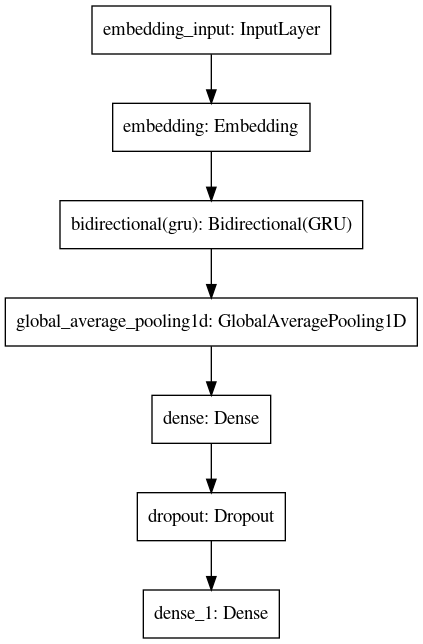

In [39]:
tf.keras.utils.plot_model(model)

In [40]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((32567, 286), (2964, 286), (32567,), (2964,))

In [41]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

## Model Training

In [42]:
num_epochs = 5
history = model.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test))

Epoch 1/5
1018/1018 [==============================] - 40s 39ms/step - loss: 0.9223 - accuracy: 0.5474 - val_loss: 0.7284 - val_accuracy: 0.6852
Epoch 2/5
1018/1018 [==============================] - 40s 39ms/step - loss: 0.5922 - accuracy: 0.7786 - val_loss: 0.5132 - val_accuracy: 0.8060
Epoch 3/5
1018/1018 [==============================] - 39s 39ms/step - loss: 0.3632 - accuracy: 0.8784 - val_loss: 0.4529 - val_accuracy: 0.8404
Epoch 4/5
1018/1018 [==============================] - 39s 39ms/step - loss: 0.2520 - accuracy: 0.9219 - val_loss: 0.4619 - val_accuracy: 0.8404
Epoch 5/5
1018/1018 [==============================] - 39s 39ms/step - loss: 0.1859 - accuracy: 0.9438 - val_loss: 0.5009 - val_accuracy: 0.8397


In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Model Accuracy and Loss

In [45]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]}")


Accuracy on training data is:- 94.38388347625732 %
Loss 0.18585143983364105
Accuracy on validation data is:- 83.97436141967773 %
Loss 0.500851035118103


## Plotting our Results

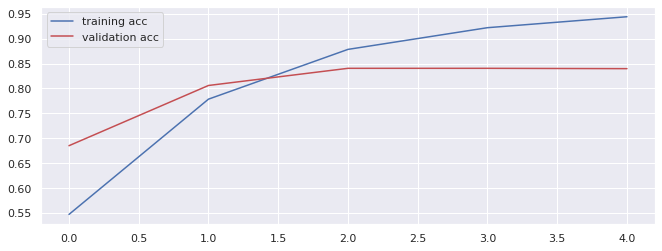

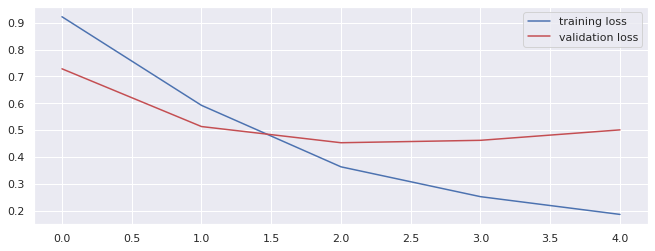

In [46]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [47]:
pred = model.predict_classes(x_test)

## Confusion Matrix

In [48]:
cm = confusion_matrix(np.argmax(y_test,1),pred)
cm

array([[ 407,   46,   44],
       [  21, 1061,  125],
       [  50,  189, 1021]])

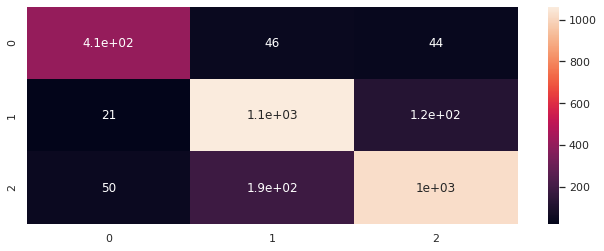

In [49]:
sns.heatmap(cm,annot=True)

### Classification Report

In [50]:
print(classification_report(np.argmax(y_test,1),pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       497
           1       0.82      0.88      0.85      1207
           2       0.86      0.81      0.83      1260

    accuracy                           0.84      2964
   macro avg       0.84      0.84      0.84      2964
weighted avg       0.84      0.84      0.84      2964

